# Deep Learning with Fully Connected Networks

### Fully connected networks are the classic starting point of neural networks. This is how word embedings are created. 

### Fully connected network consists of 
* Input layer
* Several hidden layers
* Output layer

### Again we will illistrate this classical method using the MNIST dataset. This could jest as easily be radiograph images although a great deal of data prepartation is done for us.


<BR>
<BR>
<img src="./images/fully-connected.png" width="400px"> 

#### This time we have to define an activation function for the output of our hidden layer. 

#### Why do we use the Sigmoid function instead of the step function?

<BR>
<img align="left" style="float: l;" src="./images/sigmoid-function.png" width="350px">
<img style="float: l;" src="./images/sig-derivative-graph.png" width="400px">
<img src="./images/sigmoid derivative.png" width="300px">
<BR>

# Let's define our model

In [1]:
import numpy as np
import time
import tqdm
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# This convenience function will randomly initialize our weights  to values from a normal distribution 
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

In [3]:
# Combine the previous dataset with a new dataset of cases
def update_d(prev, new):
    combined = prev.copy()
    combined.update(new)
    return combined 

# We will define a fnction to train our model and display how it is doing
def train_model(sess, train_X, train_Y, test_X, test_Y, train_operation, accuracy_operation, num_epochs, batch_size, test_size):
    accuracies = []
    train_feed = dict()
    test_feed = dict()
    startingTime = time.time()
    with tqdm.tqdm(total = num_epochs * len(train_X)) as ranger:
        for epoch in range(num_epochs): # An epoch is a run through our entire training data set
            for start in range(0, len(train_X), batch_size): # loop in batches of batch size
                end = start + batch_size
                sess.run(train_operation, feed_dict=update_d(train_feed, {X: train_X[start:end],y: train_Y[start:end]}))
                ranger.update(batch_size)
                if (start // batch_size) % 100 == 0: # Let's record accuracy every batch
                    testSet = np.random.choice(len(test_X), test_size, replace=False)
                    tstX, tstY = test_X[testSet], test_Y[testSet]
                    accuracies.append(sess.run(accuracy_operation, feed_dict = update_d(test_feed, {X: tstX, y: tstY})))
                    ranger.set_description("Test Accuracy: " + str(accuracies[-1]))
            # print out the final test accuracy                                                       
            testSet = np.random.choice(len(test_X),test_size,replace=False)
            tstX, tstY = test_X[testSet], test_Y[testSet]
            accuracies.append(sess.run(accuracy_operation, feed_dict = update_d(test_feed, {X: tstX, y: tstY})))
            ranger.set_description("Test Accuracy: " + str(accuracies[-1]))
    timeTaken = time.time() - startingTime
    print("Finished training for %d epochs" % num_epochs)
    print("Took %.02f seconds (%.02f s per epoch)" % (timeTaken, timeTaken/num_epochs))
    accuracies.append(sess.run(accuracy_operation, feed_dict = update_d(test_feed, {X:test_X, y: test_Y})))
    print("Final accuracy was %.04f" % accuracies[-1])
    plt.plot(accuracies)


In [4]:
# A placeholder is not a value! We just need to define how we will hold onto our training cases. 
# "None" means that this dimension can be any length.

# X will be our input placeholder for a image case
X = tf.placeholder("float",shape=[None,784])
# Y will be a placeholder for our output distribution
y = tf.placeholder("float",shape=[None,10])

In [5]:
# We will define our weight variables coming into the hidden layer and entering the output layer
# We take advantage of the convenience function init_weights to do this work.
NUM_HIDDEN = 620
W_h = init_weights([784,NUM_HIDDEN]) # Weights entering the hidden layer
W_o = init_weights([NUM_HIDDEN,10]) # Weights entering the output layer
b_h = init_weights([1, NUM_HIDDEN]) # Let's define our bias weights for the hidden layer
b_o = init_weights([1, 10]) # Let's define our bias weights for the output layer

In [6]:
# Let's calculate our weights between the input layer and the hidden layer
entering_hidden = tf.matmul(X,W_h) + b_h
# Let's execute our activation function on the hidden layer neurons
exiting_hidden = tf.nn.sigmoid(entering_hidden)
#Let's calculate our weights between the output of the hidden layer nad the input into our softmax output layer
y_hat = tf.matmul(exiting_hidden,W_o) + b_o

# Now we need to train our model

#### First we have to understand what it means  for a model to be good! IN machine learning we actually define what it means for a model to be bad. We call this our cost of loss function. Our goal is to minimize our loss.

#### A commonly used loss function is "cross-entropy". Cross-entropy loss increases as the predicted probability diverges from the actual label. It looks something like this . . .

<BR>
<img src="./images/cross_entropy.png" width="400px"> 
<BR>

<center>$H_{y'}(y) = - \displaystyle \sum_{i} y'_i \space log(y_i) $</center>

#### Where  <i>y</i> is our predicted probability distribution, <i>y'</i> is our true distribution (the one-hot vector with the digit labels).

#### When we calcualte our evidence we end up with unnormalized log probabilities such as below . . .

$evidence_i = \displaystyle \sum_{j=0} p(\space W_{i,j} \space x_j \space + \space b_i) $

#### Let's assume a 3 class problem . . . 
* Training Case 1 Prediction: [ 0.5,  1.5,  0.1]
* Training Case 2 Prediction: [ 2.2,  1.3,  1.7]

#### These outputs do not sum to one, that is they are unromalized probabilities

#### Now Softmax is going to normalize these into linear probabilites

$y_{hat} = softmax(evidence)$

* Training Case 1 Softmax: [0.227863, 0.61939586, 0.15274114]
* Training Case 2 Softmax: [0.49674623,0.20196195,0.30129182]

In [7]:
# Now we can define our loss function. Cross entropy with logits and we average across our batch.
# We generate unnormalized log probabilities (aka logits) and we want the outputs normalized linear probabilities
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=y_hat))

#### Gradient Descent
<BR>
<img align="left" style="float: l;" src="./images/gd.png" width="400px">

<img style="float: l;" src="./images/gd-learning.png" width="350px">
<BR>

In [8]:
# Define our gradient descent optimizer
# We want to minimize our loss function, that is cross entropy. We will set a learning rate of 0.5
train_operation = tf.train.GradientDescentOptimizer(0.2).minimize(cross_entropy)

In [9]:
# Let's read in our MNIST data
mnist = input_data.read_data_sets("data", one_hot=True)
trX, trY = mnist.train.images, mnist.train.labels
tstX, tstY = mnist.test.images, mnist.test.labels

Extracting data\train-images-idx3-ubyte.gz
Extracting data\train-labels-idx1-ubyte.gz
Extracting data\t10k-images-idx3-ubyte.gz
Extracting data\t10k-labels-idx1-ubyte.gz


Test Accuracy: 0.9783: 100%|██████████████████████████████████████████████| 2750000/2750000 [03:21<00:00, 13660.29it/s]


Finished training for 50 epochs
Took 201.32 seconds (4.03 s per epoch)
Final accuracy was 0.9783


(0.8, 1)

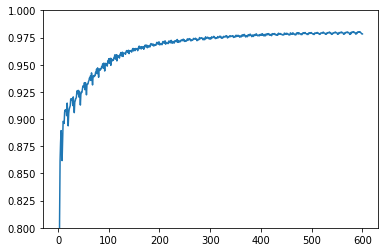

In [10]:
# Let's define our prediction operation, that is the largest probability among our 10 possible output labels
predict_operation = tf.argmax(y_hat, 1)
# Let's define our accuracy operation
accuracy_operation = tf.reduce_mean(tf.cast(tf.equal(predict_operation,tf.argmax(y,1)),tf.float32))
 
NUM_EPOCHS = 50 # Number of complte time through our traing data
BATCH_SIZE = 50 # Training batches
accuracies = []
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    train_model(sess, trX, trY, tstX, tstY, train_operation, accuracy_operation, NUM_EPOCHS, BATCH_SIZE, 10000)
plt.ylim(.8,1)

#### How many hidden neurons do I really need?